In [1]:
import os


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pickle import dump
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [55]:
folders = ['vm/3high-3low/0iid', 'vm/3high-3low/100iid',
           'vm/5high-5low/0iid', 'vm/5high-5low/100iid',
           'vm/10high-10low/0iid', 'vm/10high-10low/100iid',
           'vm/4high-2low/0iid', 'vm/4high-2low/100iid',
           'vm/8high-4low/0iid', 'vm/8high-4low/100iid',
           'vm/2high-4low/0iid', 'vm/2high-4low/100iid',
           'vm/4high-8low/0iid', 'vm/4high-8low/100iid',
           'vm/2high-8low/0iid', 'vm/2high-8low/100iid']
exp_data: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if 'always-selector' in exp_path:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df = df[df['Val F1'] >= 0]
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[1].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[1].split('high-')[1].split('low')[0])
            # print(folder, exp, last_client, df['High-Spec Clients'].unique(), df['Low-Spec Clients'].unique())
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) == min(last_client))
            df = df[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round', 'Selector',
                     'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data = pd.concat([exp_data, df])

print(exp_data)

     High-Spec Clients  Low-Spec Clients  IID Data  FL Round  Selector  \
5                    3                 3         0         2      True   
8                    3                 3         0         3      True   
11                   3                 3         0         4      True   
17                   3                 3         0         5     False   
20                   3                 3         0         6      True   
..                 ...               ...       ...       ...       ...   
103                  2                 8       100        16     False   
113                  2                 8       100        17     False   
123                  2                 8       100        18     False   
133                  2                 8       100        19     False   
135                  2                 8       100        20      True   

     Total Time of FL Round  Previous F1/Time  Previous Val F1   F1/Time  \
5                     54.75        

In [66]:
x = exp_data[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'Previous F1/Time']]
y = exp_data[['F1/Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8215)

tree_f1overtime = DecisionTreeRegressor(max_depth=5)
tree_f1overtime.fit(x_train, y_train)

print(tree_f1overtime.score(x_train, y_train))
print(tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_regressor_{}.pkl".format(len(x_train)), "wb") as f:
    dump(tree_f1overtime, f, protocol=5)

0.8947118396230145
0.8776875856750661


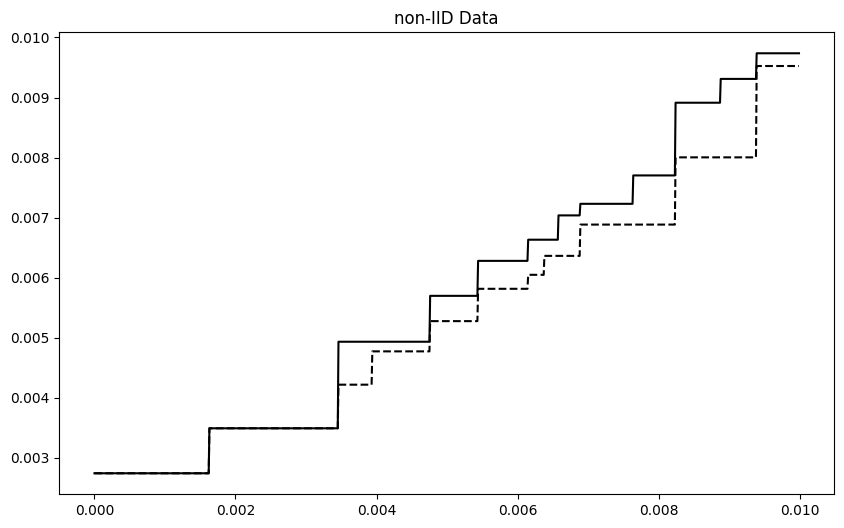

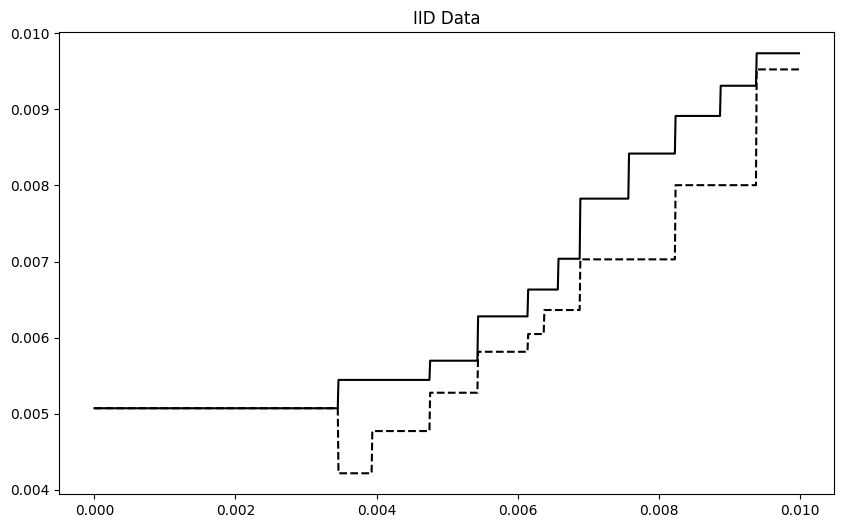

In [74]:
N_high = 5
N_low = 5

x = np.arange(0, 0.01, 0.00001)

plt.figure(figsize=(10, 6))

plt.plot(x, [tree_f1overtime.predict([[N_high, N_low, 0, True, v]])[0] for v in x], color="black")
plt.plot(x, [tree_f1overtime.predict([[N_high, N_low, 0, False, v]])[0] for v in x], '--', color="black")

plt.title('non-IID Data')

plt.show()

plt.figure(figsize=(10, 6))

plt.plot(x, [tree_f1overtime.predict([[N_high, N_low, 100, True, v]])[0] for v in x], color="black")
plt.plot(x, [tree_f1overtime.predict([[N_high, N_low, 100, False, v]])[0] for v in x], '--', color="black")

plt.title('IID Data')

plt.show()

In [4]:
# Features and target
x = exp_data[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'FL Round']]
y = exp_data['F1/Time']

# Standardize input (important for GPR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# Fit model
gpr.fit(X_train, y_train)

# Predict on test set
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [2.00000000e+00 8.00000000e+00 7.10542736e-15 1.00000000e+00
 1.90000000e+01] → Predicted accuracy: 0.008 ± 0.000
Input: [1.00000000e+01 1.00000000e+01 7.10542736e-15 1.00000000e+00
 1.90000000e+01] → Predicted accuracy: 0.007 ± 0.000
Input: [ 5.  5. 40.  1.  4.] → Predicted accuracy: 0.006 ± 0.000
Input: [4.00000000e+00 2.00000000e+00 7.10542736e-15 1.00000000e+00
 1.00000000e+01] → Predicted accuracy: 0.006 ± 0.000
Input: [  4.   2. 100.   1.  20.] → Predicted accuracy: 0.010 ± 0.000
Input: [4.00000000e+00 2.00000000e+00 7.10542736e-15 1.00000000e+00
 1.20000000e+01] → Predicted accuracy: 0.007 ± 0.000
Input: [ 10.  10. 100.   1.   6.] → Predicted accuracy: 0.007 ± 0.000
Input: [ 5.  5. 40.  1.  6.] → Predicted accuracy: 0.006 ± 0.000
Input: [  4.   2. 100.   1.   9.] → Predicted accuracy: 0.009 ± 0.000
Input: [1.00000000e+01 1.00000000e+01 7.10542736e-15 0.00000000e+00
 1.60000000e+01] → Predicted accuracy: 0.006 ± 0.000
Input: [  2.   4. 100.   1.   4.] → Predicted accuracy:

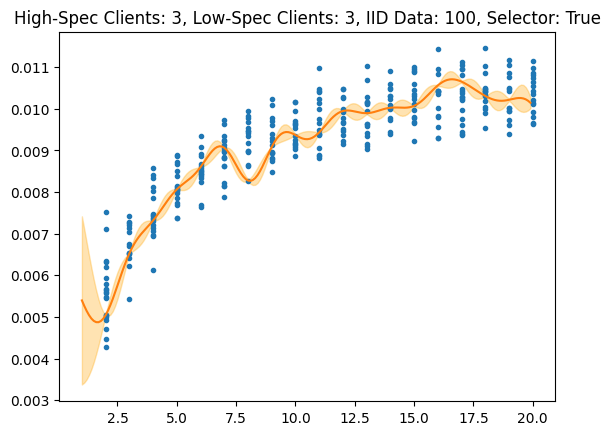

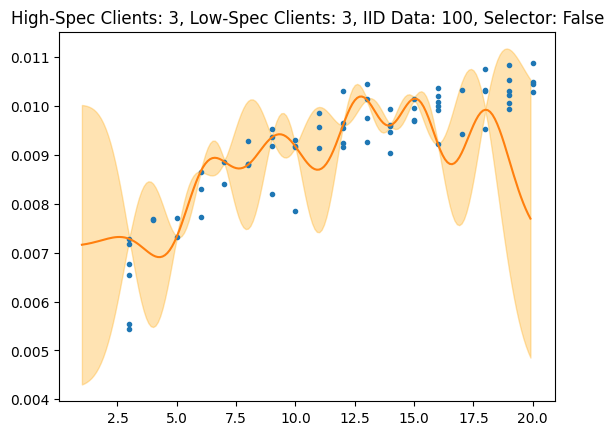

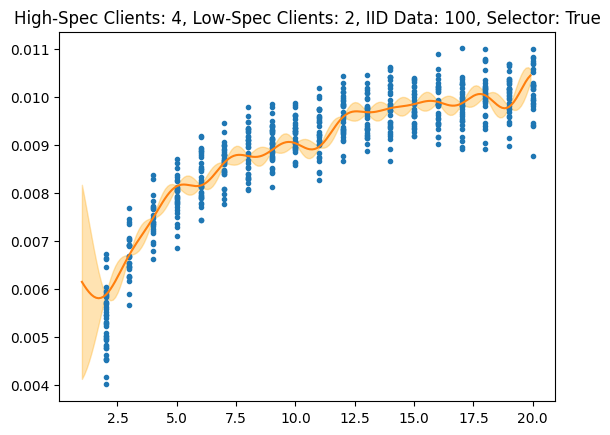

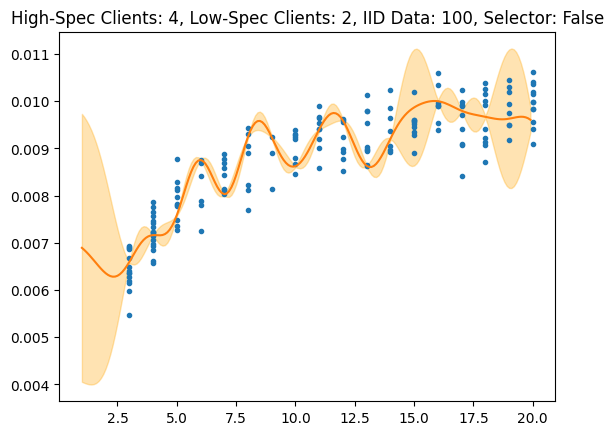

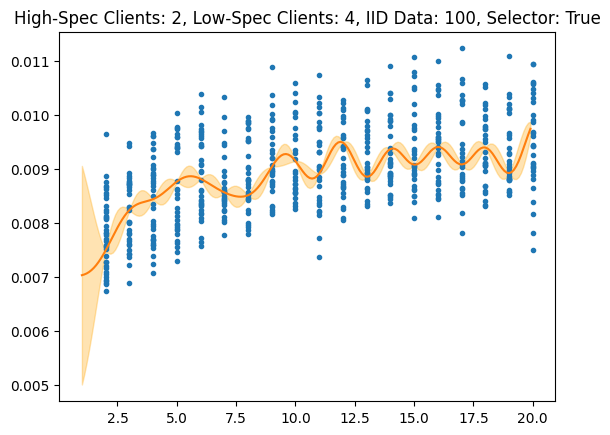

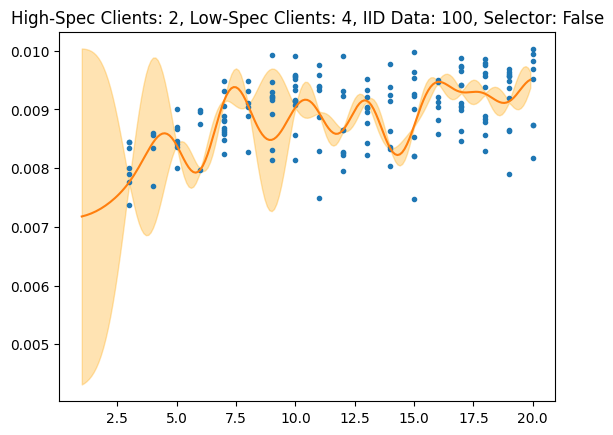

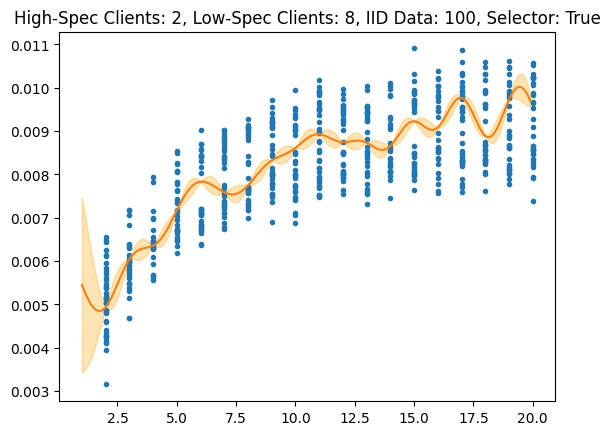

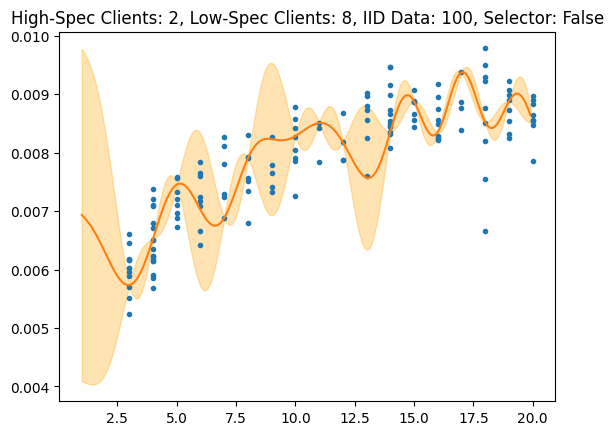

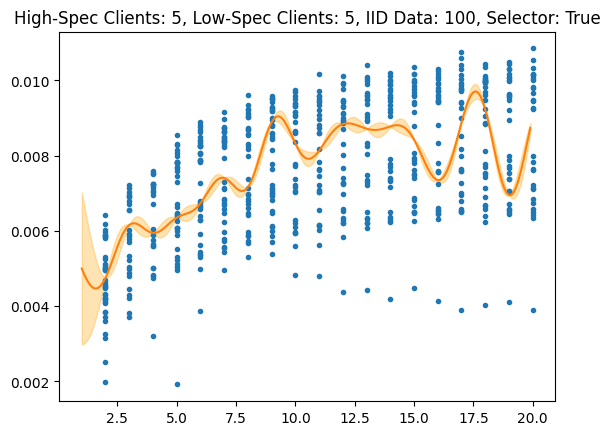

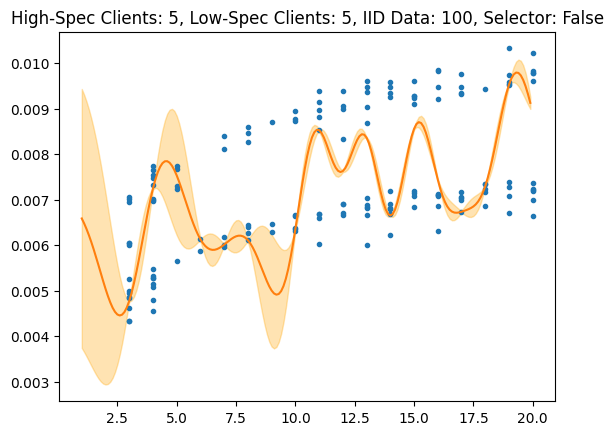

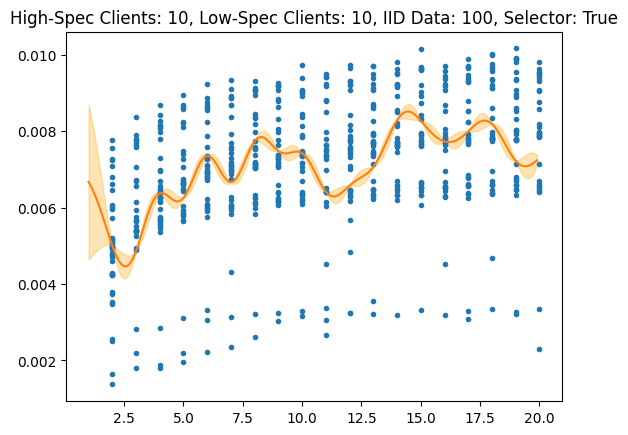

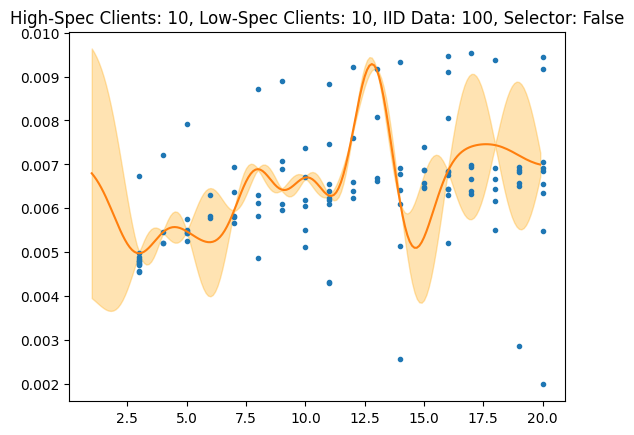

In [5]:
def plot_gp(high_spec, low_spec, iid, selector):
    # Visualization
    x = exp_data[(exp_data['High-Spec Clients'] == high_spec) & (exp_data['Low-Spec Clients'] == low_spec) & (
            exp_data['IID Data'] == iid) & (exp_data['Selector'] == selector)]['FL Round']
    y = exp_data[(exp_data['High-Spec Clients'] == high_spec) & (exp_data['Low-Spec Clients'] == low_spec) & (
            exp_data['IID Data'] == iid) & (exp_data['Selector'] == selector)]['F1/Time']

    # Vary high_spec_clients from 1 to 10
    X_plot = pd.DataFrame({
        'High-Spec Clients': high_spec,
        'Low-Spec Clients': low_spec,
        'IID Data': iid,
        'Selector': selector,
        'FL Round': np.arange(1, 20, 0.1)
    })

    # Scale features
    X_plot_scaled = scaler.transform(X_plot)

    # Predict mean and std
    y_pred, y_std = gpr.predict(X_plot_scaled, return_std=True)

    plt.figure()
    plt.plot(x, y, '.')
    plt.plot(X_plot['FL Round'], y_pred, label='Predicted accuracy')
    plt.fill_between(X_plot['FL Round'], y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.3, label='±1 std. dev.',
                     color='orange')
    plt.title(f'High-Spec Clients: {high_spec}, Low-Spec Clients: {low_spec}, IID Data: {iid}, Selector: {selector}')
    plt.show()


clients = [(3, 3), (4, 2), (2, 4), (2, 8), (5, 5), (10, 10)]
for pair in clients:
    plot_gp(pair[0], pair[1], 100, True)
    plot_gp(pair[0], pair[1], 100, False)


In [9]:
from skopt import gp_minimize


def objective(policy_on):  # binary: 0 or 1
    X = [[3, 3, 100, policy_on[0], 15]]
    X_scaled = scaler.transform(X)
    y_pred = -gpr.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


res = gp_minimize(objective,  # objective fn
                  [(0, 1)],  # policy_on ∈ {0,1}
                  acq_func="EI",  # acquisition function
                  n_calls=10, random_state=42)

# Best parameters found
print("Best policy setting (policy_on):", res.x[0])
print("Best (maximized) accuracy (approx):", -res.fun)

# All tried values and corresponding scores
print("All policy values tried:", res.x_iters)
print("Corresponding (negated) accuracies:", [-f for f in res.func_vals])

Best policy setting (policy_on): 0
Best (maximized) accuracy (approx): 0.010153253237671488
All policy values tried: [[1], [0], [1], [1], [0], [0], [0], [0], [0], [1]]
Corresponding (negated) accuracies: [0.010071947081944633, 0.010153253237671488, 0.010071947081944633, 0.010071947081944633, 0.010153253237671488, 0.010153253237671488, 0.010153253237671488, 0.010153253237671488, 0.010153253237671488, 0.010071947081944633]
